In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [32]:
# Parameters
D = 1.0  # Diffusion coefficient
r_max = 10  # a
N = 50  # Number of spatial points
dr = r_max / N  # Spatial step size

# Spatial grid (excluding the center point r=0 to avoid singularity)
r = np.linspace(dr, r_max, N)

# Initial condition (example: Gaussian distribution)
#C0 = np.exp(-r**2)
C0 = np.where(r < 5, 0.0, 1.)

In [33]:
def dCdt(C, t, r, D, dr, N):
    # Initialize dCdt vector
    dCdt = np.zeros(N)

    # Interior points
    for i in range(1, N-1):
        dCdt[i] = (D/dr**2) * (r[i+1]*C[i+1] - 2*r[i]*C[i] + r[i-1]*C[i-1])

    # Boundary conditions
    dCdt[0] = (D/dr**2) * (r[1]*C[1] - 2*r[0]*C[0])
    dCdt[N-1] = (D/dr**2) * (-r[N-1]*C[N-1] + r[N-2]*C[N-2])

    return dCdt

In [34]:
# Time points where the solution is computed
t = np.linspace(0, 10, 100)

# Solve PDE
solution = odeint(dCdt, C0, t, args=(r, D, dr, N))

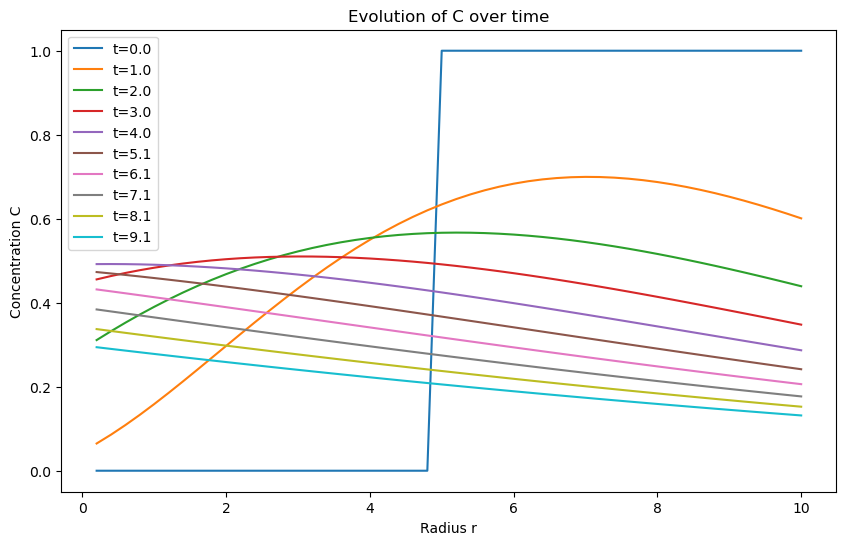

In [35]:
plt.figure(figsize=(10, 6))
for i in range(0, len(t), 10):
    plt.plot(r, solution[i], label=f't={t[i]:.1f}')
plt.title('Evolution of C over time')
plt.xlabel('Radius r')
plt.ylabel('Concentration C')
plt.legend()

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [ ]:
D = 6e-10  # coefficient de diffusion
r_max = 0.0017  # rayon de la spaghetti
N = 50  # nombre de points

Ci = 0.264  # humidité interne initiale
C0 = 0.81  # humidité à la surface (constante)

In [ ]:
dr = r_max / N  # taille de la "maille"
r = np.linspace(dr, r_max, N)

initial_condition = Ci * np.ones(N)

In [ ]:
def dCdt(C, t, r, D, dr, N, C0):
    dCdt = np.zeros(N)

    for i in range(1, N-1):
        dCdt[i] = D * ((C[i+1] - 2*C[i] + C[i-1]) / dr**2 + (C[i+1] - C[i-1]) / (2*dr*r[i]))

    # CL : Dirichlet 
    dCdt[N-1] = D * ((C0 - 2*C[N-1] + C[N-2]) / dr**2 + (C0 - C[N-2]) / (2*dr*r[N-1]))
    return dCdt

In [48]:
t = np.linspace(0, 10000, 10000)
solution = odeint(dCdt, initial_condition, t, args=(r, D, dr, N, C0))

In [53]:
t[(solution[:, 4] > 0.35).argmax()] if np.any(solution[:, 4] > 0.35) else None

632.063206320632

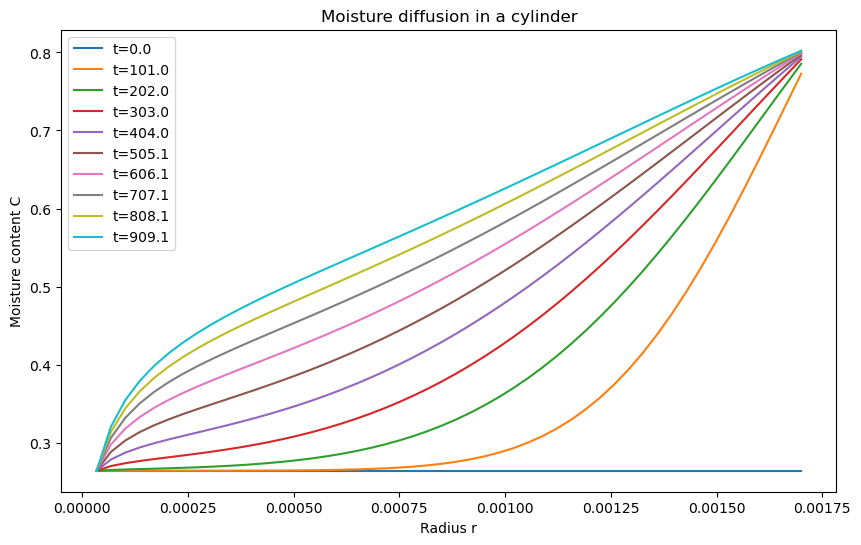

In [6]:
plt.figure(figsize=(10, 6))
for i in range(0, len(t), 10):
    plt.plot(r, solution[i], label=f't={t[i]:.1f}')
plt.title('Moisture diffusion in a cylinder')
plt.xlabel('Radius r')
plt.ylabel('Moisture content C')
plt.legend()